In [1]:
from datetime import datetime
from random import randint
import pandas as pd
import pickle
import collections
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nsamples = 65100
df_week1 = pd.read_csv("C:/Users/Akarsh/Downloads/WISENT-CIDDS-001/CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv").sample(n=nsamples)
df_week2 = pd.read_csv("C:/Users/Akarsh/Downloads/WISENT-CIDDS-001/CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week2.csv").sample(n=nsamples)
df_week3 = pd.read_csv("C:/Users/Akarsh/Downloads/WISENT-CIDDS-001/CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week3.csv").sample(n=nsamples)
df_week4 = pd.read_csv("C:/Users/Akarsh/Downloads/WISENT-CIDDS-001/CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week4.csv").sample(n=nsamples)

frames = [df_week1, df_week2, df_week3, df_week4]
train_data = pd.concat(frames)
print(train_data.shape)

del df_week1, df_week2, df_week3, df_week4

train_data = train_data.sample(frac=1).reset_index(drop=True)

print(train_data['Proto'].unique(), '\n')
print(train_data['class'].unique(), '\n')
print(train_data['Flags'].unique(), len(train_data['Flags'].unique()), '\n')

indexNames = train_data[train_data['Proto'].str.match('IGMP', na=False)].index
train_data.drop(indexNames, inplace=True)
print(train_data.shape)
print(train_data['Proto'].unique())

display(train_data.head())
del indexNames

c:\users\akarsh\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(260400, 16)
['UDP  ' 'TCP  ' 'ICMP ' 'IGMP '] 

['normal' 'victim' 'attacker'] 

['......' '.AP...' '.A....' '.A..S.' '.A...F' '.A..SF' '...R..' '.AP.S.'
 '.AP.SF' '.AP..F' '....S.' '.A.R..' '.APRSF' '.A.R.F' '.APR..' '.APR.F'
 '.APRS.' '.A.RS.' '...RS.' '.A.RSF'] 20 

(260391, 16)
['UDP  ' 'TCP  ' 'ICMP ']


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-20 11:03:29.789,0.00,UDP,192.168.220.10,42968,DNS,53.0,2,176,1,......,0,normal,---,---,---
1,2017-03-20 16:54:11.971,0.64,TCP,10086_192,80,192.168.220.14,43392.0,6,3230,1,.AP...,32,normal,---,---,---
2,2017-04-14 18:19:42.203,0.00,TCP,16569_82,80,192.168.220.8,41440.0,1,66,1,.A....,32,normal,---,---,---
3,2017-03-18 11:08:00.553,0.00,TCP,10296_238,443,192.168.200.9,59692.0,2,154,1,.AP...,32,normal,---,---,---
4,2017-03-18 17:51:09.047,0.00,TCP,192.168.220.14,52236,10056_243,443.0,1,66,1,.A....,0,normal,---,---,---


In [3]:
# clean data
def clean_data(train_data):
    print("cleaning data...")
    process_data = []
    for row in train_data.values:
        date  = row[0].strip()
        datetime_object = datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f")
        week_day = datetime_object.weekday()
        time  = row[0].strip().split(" ")[1]
        res = []
        res.append(week_day)
        res.append(time)
        for j in range(1,14):
            if j == 9 or j == 11:
                continue
            if j == 8:
                if type(row[j]) == int:
                    res.append(int(row[j]))
                else:
                    bytzes = row[j].strip()
                    if "M" in bytzes:
                        bytzes = float( bytzes.split(" ")[0] )
                        bytzes = int( bytzes * 1024 * 1024 )# Conv to Bytes
                    res.append(int(bytzes))
            else:
                if type(row[j]) == str:
                    res.append(row[j].strip())
                else:
                    res.append(row[j])
        process_data.append(res)
    return process_data

col_names = ['Day', 'Time', 'Duration', 'Proto', 'Src IP Addr', 'Src Pt', 'Dst IP Addr', 'Dst Pt', 'Packets', 'Bytes', 'Flags', 'class', 'attackType']
process_data = clean_data(train_data)
updated_train = pd.DataFrame(process_data, columns = col_names)

display(updated_train.head())
display(updated_train.describe())
display(updated_train.info())

updated_train['Dst Pt'] = updated_train['Dst Pt'].astype('int64')
display(updated_train.info())
display(updated_train.head())

cleaning data...


,Day,Time,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flags,class,attackType
0,0,11:03:29.789,0.00,UDP,192.168.220.10,42968,DNS,53.0,2,176,......,normal,---
1,0,16:54:11.971,0.64,TCP,10086_192,80,192.168.220.14,43392.0,6,3230,.AP...,normal,---
2,4,18:19:42.203,0.00,TCP,16569_82,80,192.168.220.8,41440.0,1,66,.A....,normal,---
3,5,11:08:00.553,0.00,TCP,10296_238,443,192.168.200.9,59692.0,2,154,.AP...,normal,---
4,5,17:51:09.047,0.00,TCP,192.168.220.14,52236,10056_243,443.0,1,66,.A....,normal,---


,Day,Duration,Src Pt,Dst Pt,Packets,Bytes
count,260391.000000,260391.000000,260391.000000,260391.000000,260391.000000,2.603910e+05
mean,2.366288,0.126139,24759.687209,24402.750514,16.475462,2.094636e+04
std,1.613342,0.710818,25148.739218,25130.514122,994.716635,2.179878e+06
min,0.000000,0.000000,0.000000,0.000000,1.000000,4.200000e+01
25%,1.000000,0.000000,80.000000,80.000000,1.000000,6.600000e+01
50%,2.000000,0.000000,8082.000000,8082.000000,2.000000,1.400000e+02
75%,4.000000,0.032000,50232.500000,50076.000000,3.000000,4.440000e+02
max,6.000000,111.785000,65534.000000,65535.000000,165278.000000,4.868538e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260391 entries, 0 to 260390
Data columns (total 13 columns):
Day            260391 non-null int64
Time           260391 non-null object
Duration       260391 non-null float64
Proto          260391 non-null object
Src IP Addr    260391 non-null object
Src Pt         260391 non-null int64
Dst IP Addr    260391 non-null object
Dst Pt         260391 non-null float64
Packets        260391 non-null int64
Bytes          260391 non-null int64
Flags          260391 non-null object
class          260391 non-null object
attackType     260391 non-null object
dtypes: float64(2), int64(4), object(7)
memory usage: 25.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260391 entries, 0 to 260390
Data columns (total 13 columns):
Day            260391 non-null int64
Time           260391 non-null object
Duration       260391 non-null float64
Proto          260391 non-null object
Src IP Addr    260391 non-null object
Src Pt         260391 non-null int64
Dst IP Addr    260391 non-null object
Dst Pt         260391 non-null int64
Packets        260391 non-null int64
Bytes          260391 non-null int64
Flags          260391 non-null object
class          260391 non-null object
attackType     260391 non-null object
dtypes: float64(1), int64(5), object(7)
memory usage: 25.8+ MB


None

,Day,Time,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flags,class,attackType
0,0,11:03:29.789,0.00,UDP,192.168.220.10,42968,DNS,53,2,176,......,normal,---
1,0,16:54:11.971,0.64,TCP,10086_192,80,192.168.220.14,43392,6,3230,.AP...,normal,---
2,4,18:19:42.203,0.00,TCP,16569_82,80,192.168.220.8,41440,1,66,.A....,normal,---
3,5,11:08:00.553,0.00,TCP,10296_238,443,192.168.200.9,59692,2,154,.AP...,normal,---
4,5,17:51:09.047,0.00,TCP,192.168.220.14,52236,10056_243,443,1,66,.A....,normal,---


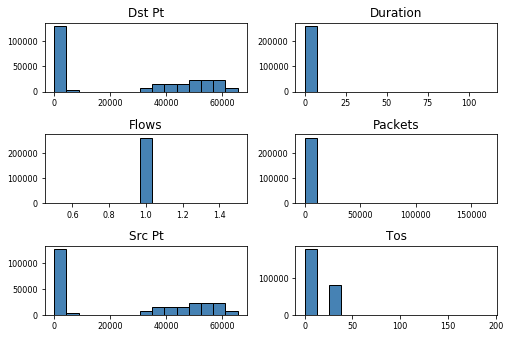

In [4]:
train_data.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))

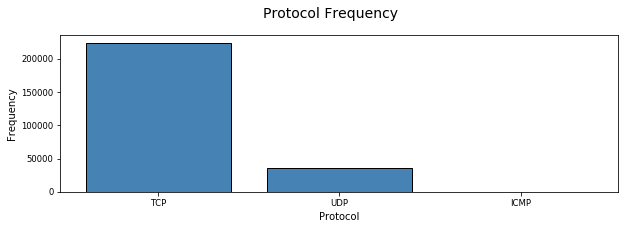

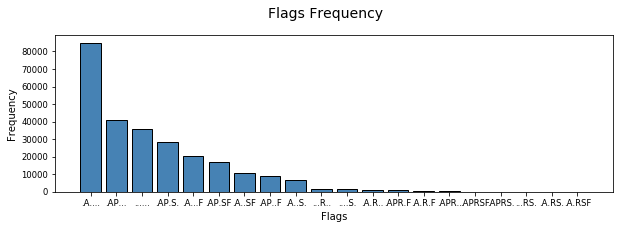

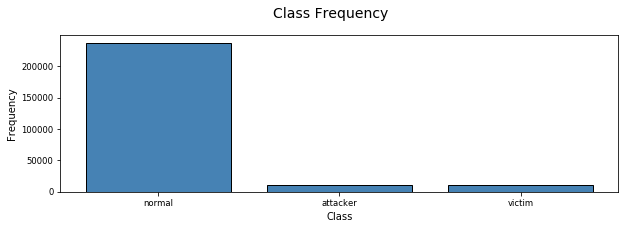

In [5]:
def plot_freq(data, title_):
    fig = plt.figure(figsize = (10, 3))
    title = fig.suptitle(title_ + " Frequency", fontsize=14)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(title_)
    ax.set_ylabel("Frequency") 
    w_q = data.value_counts()
    w_q = (list(w_q.index), list(w_q.values))
    ax.tick_params(axis='both', which='major', labelsize=8.5)
    bar = ax.bar(w_q[0], w_q[1], color='steelblue', 
            edgecolor='black', linewidth=1)

plot_freq(updated_train['Proto'], "Protocol")
plot_freq(updated_train['Flags'], "Flags")
plot_freq(updated_train['class'], "Class")

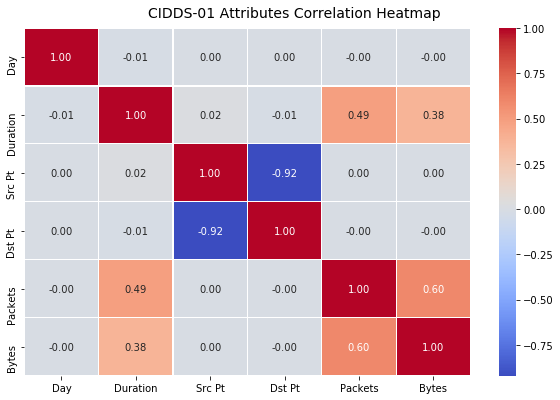

In [6]:
f, ax = plt.subplots(figsize=(10, 6))
corr = updated_train.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('CIDDS-01 Attributes Correlation Heatmap', fontsize=14)

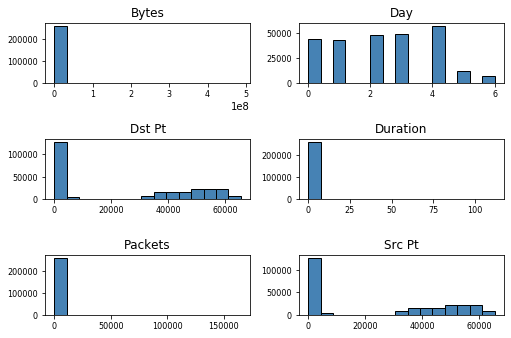

In [7]:
updated_train.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [8]:
# convert to IP2Vec format
new_col_names = ["srcIP", "srcPt", "dstIP", "dstPt", "proto", "packets", "bytes", "duration"]

ip2vec_format = []
for row in updated_train.values:
    proto = row[3].strip()
    srcIP = row[4].strip()
    srcPt = str(row[5]).strip() + "_p"
    dstIP = row[6].strip()
    dstPt = str(row[7]).strip() + "_p"
    bytez = str(row[9]).strip() + "_b"
    packets = str(row[8]).strip() + "_k"
    duration = str(row[2]).strip() + "_d"
    ip2vec_format.append([srcIP, srcPt, dstIP, dstPt, proto, packets, bytez, duration])

ip2vec_train = pd.DataFrame(ip2vec_format, columns = new_col_names)
display(ip2vec_train.head())
print(ip2vec_train.shape)

,srcIP,srcPt,dstIP,dstPt,proto,packets,bytes,duration
0,192.168.220.10,42968_p,DNS,53_p,UDP,2_k,176_b,0.0_d
1,10086_192,80_p,192.168.220.14,43392_p,TCP,6_k,3230_b,0.64_d
2,16569_82,80_p,192.168.220.8,41440_p,TCP,1_k,66_b,0.0_d
3,10296_238,443_p,192.168.200.9,59692_p,TCP,2_k,154_b,0.0_d
4,192.168.220.14,52236_p,10056_243,443_p,TCP,1_k,66_b,0.0_d


(260391, 8)


In [9]:
def save2file(filename, data):
    pickle_out = open("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/" + filename + ".pickle", "wb")
    pickle.dump(data, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
    pickle_out.close()

main_str = str(randint(0, 1000))
print(main_str)

filename = "updated_train_"  + main_str
save2file(filename, updated_train)

filename = "ip2vec_train_" + main_str
save2file(filename, ip2vec_train)

437


In [10]:
save = True
if save:
    df = pd.DataFrame.from_records([{'operation': 'ip2vec_preprocess', 'main_str': main_str, 'num_samples': nsamples}])
    df.to_csv("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/store_params.csv", mode='a', index=False)
    print('data and hyperparams saved...')

data and hyperparams saved...
